## Overall Goal

Our goal is to create and fine-tune VLLM that successfully extract information from a given scanned document. Regardless if it's handwritten or digital. We have choosen existing VLLM model LayoutLM and will fine-tune it for our desired usage. LayoutLM is simple but effective pretraining method of text and layout for document image understanding and information extraction tasks. We will use LayoutLMv3 pretraining for Document AI with unified text and image masking.



## Loading The Datasets

In [11]:
from datasets import load_dataset

# this dataset uses the new Image feature
dataset = load_dataset("nielsr/funsd-layoutlmv3")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


funsd-layoutlmv3.py:   0%|          | 0.00/5.13k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/9.54M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/149 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 50
    })
})

In [13]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(mode=None, decode=True, id=None)}

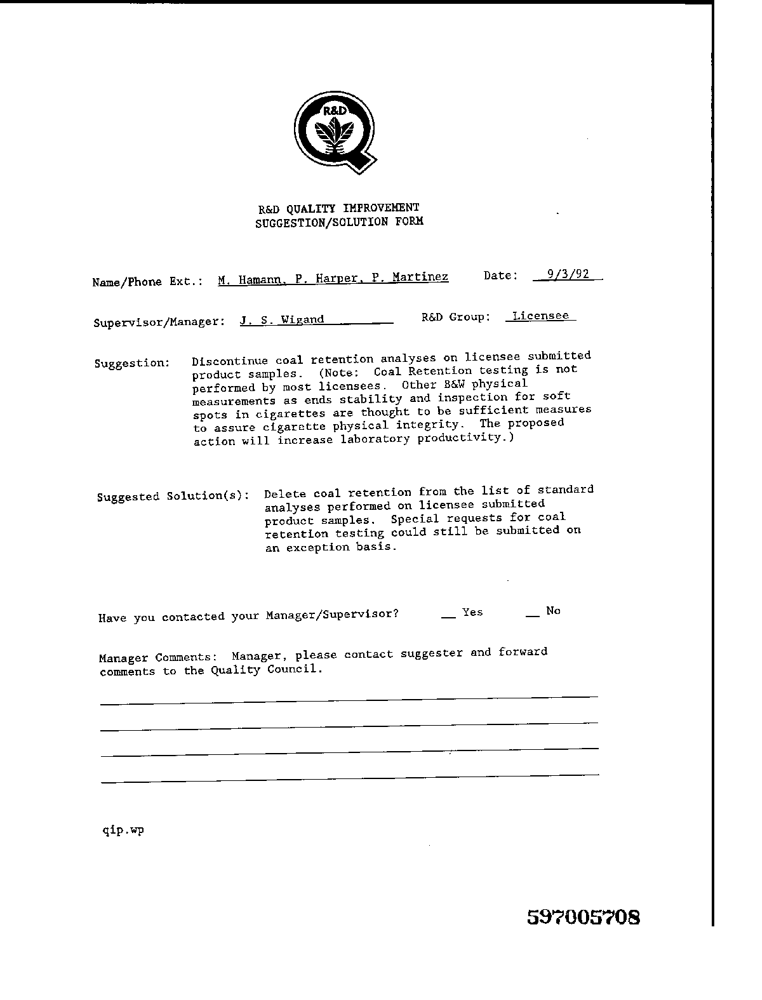

In [14]:
example = dataset["train"][0]
example["image"]

In [15]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['R&D', ':', 'Suggestion:', 'Date:', 'Licensee', 'Yes', 'No', '597005708', 'R&D', 'QUALITY', 'IMPROVEMENT', 'SUGGESTION/', 'SOLUTION', 'FORM', 'Name', '/', 'Phone', 'Ext.', ':', 'M.', 'Hamann', 'P.', 'Harper,', 'P.', 'Martinez', '9/', '3/', '92', 'R&D', 'Group:', 'J.', 'S.', 'Wigand', 'Supervisor', '/', 'Manager', 'Discontinue', 'coal', 'retention', 'analyses', 'on', 'licensee', 'submitted', 'product', 'samples', '(Note', ':', 'Coal', 'Retention', 'testing', 'is', 'not', 'performed', 'by', 'most', 'licensees.', 'Other', 'B&W', 'physical', 'measurements', 'as', 'ends', 'stability', 'and', 'inspection', 'for', 'soft', 'spots', 'in', 'ciparettes', 'are', 'thought', 'to', 'be', 'sufficient', 'measures', 'to', 'assure', 'cigarette', 'physical', 'integrity.', 'The', 'proposed', 'action', 'will', 'increase', 'laboratory', 'productivity', '.', ')', 'Suggested', 'Solutions', '(s)', ':', 'Delete', 'coal', 'retention', 'from', 'the', 'list', 'of', 'standard', 'analyses', 'performed', 'on', 'licen

## DATASET preparation

In [16]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [17]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [18]:
print(label_list)

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [19]:
print(id2label)

{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}


In [20]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [21]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [22]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 149
})

In [23]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity . ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip . wp</s><pad><pad><pad><pad><pad><pad><pad>

In [24]:
train_dataset.set_format("torch")

In [25]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [26]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 50
})

In [27]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

"<s> TO: DATE: 3 Fax: NOTE: 82092117 614 -466 -5087 Dec 10 '98 17 :46 P. 01 ATT. GEN. ADMIN. OFFICE Attorney General Betty D. Montgomery CONFIDENTIAL FACSIMILE TRANSMISSION COVER SHEET (614) 466- 5087 FAX NO. George Baroody (336) 335- 7392 FAX NUMBER: PHONE NUMBER: (336) 335- 7363 NUMBER OF PAGES INCLUDING COVER SHEET: June Flynn for Eric Brown/ (614) 466- 8980 SENDER /PHONE NUMBER: SPECIAL INSTRUCTIONS: IF YOU DO NOT RECEIVE ANY OF THE PAGES PROPERLY, PLEASE CONTACT SENDER AS SOON AS POSSIBLE THIS MESSAGE IS INTENDED ONLY FOR THE USE OF THE INDIVIDUAL OR ENTITY TO WHOM IT IS ADDRESSED AND MAY CONTAIN INFORMATION THAT IS PRIVILEGED. CONFIDENTIAL, AND EXEMPT FROM DISCLOSURE UNDER APPLICABLE LAW. If the reader of this message is not the intended recipient of the employee or agent responsible for delivering the message to the intended recipient, you are hereby notified that any dissemination, distribution, copying, or conveying of this communication in any manner is strictly prohibited. I

In [28]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 R 0
& -100
D -100
 : 3
 Suggest 3
ion -100
: -100
 Date 3
: -100
 License 5
e -100
 Yes 3
 No 3
 5 0
97 -100
005 -100
708 -100
 R 1
& -100
D -100
 QU 2
AL -100
ITY -100
 IM 2
PROV -100
EMENT -100
 S 2
UG -100
G -100
EST -100
ION -100
/ -100
 SOL 2
UTION -100
 FORM 2
 Name 3
 / 4
 Phone 4
 Ext 4
. -100
 : 4
 M 5
. -100
 Ham 6
ann -100
 P 6
. -100
 Harper 6
, -100
 P 6
. -100
 Martinez 6
 9 5
/ -100
 3 6
/ -100
 92 6
 R 3
& -100
D -100
 Group 4
: -100
 J 5
. -100
 S 6
. -100
 W 6
ig -100
and -100
 Supervisor 3
 / 4
 Manager 4
 Disc 5
ont -100
in -100
ue -100
 coal 6
 retention 6
 analyses 6
 on 6
 licensee 6
 submitted 6
 product 6
 samples 6
 ( 6
Note -100
 : 6
 Coal 6
 Ret 6
ention -100
 testing 6
 is 6
 not 6
 performed 6
 by 6
 most 6
 license 6
es -100
. -100
 Other 6
 B 6
& -100
W -100
 physical 6
 measurements 6
 as 6
 ends 6
 stability 6
 and 6
 inspection 6
 for 6
 soft 6
 spots 6
 in 6
 c 6
ip -100
arettes -100
 are 6
 thought 6
 to 6
 be 6
 sufficient 6
 measures 6
 

## Define Metrics

In [29]:
import evaluate

metric = evaluate.load("seqeval")

In [30]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Defining the model

In [31]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining the training arguments

In [37]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  eval_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [38]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-38-40bb2881a99e>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train the model

In [40]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hikmetroman (hikmetroman-constructir-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1563: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.585815,0.765646,0.832588,0.797715,0.804707
200,No log,0.542683,0.831579,0.863388,0.847185,0.825508
300,No log,0.494825,0.860644,0.889717,0.874939,0.851777
400,No log,0.488721,0.875483,0.901143,0.888127,0.859384
500,0.512700,0.540828,0.872464,0.897168,0.884644,0.854867
600,0.512700,0.535448,0.886163,0.897168,0.891632,0.859265
700,0.512700,0.619250,0.876573,0.899652,0.887963,0.849994
800,0.512700,0.639243,0.889810,0.906607,0.898130,0.854154
900,0.512700,0.638692,0.890465,0.904620,0.897486,0.849756
1000,0.123600,0.635728,0.895537,0.907104,0.901283,0.854154


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1563: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.3181524925231934, metrics={'train_runtime': 577.9048, 'train_samples_per_second': 3.461, 'train_steps_per_second': 1.73, 'total_flos': 523783817001984.0, 'train_loss': 0.3181524925231934, 'epoch': 13.333333333333334})

## Evaluation:


In [41]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1563: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.6357275247573853,
 'eval_precision': 0.8955370279548799,
 'eval_recall': 0.907103825136612,
 'eval_f1': 0.9012833168805527,
 'eval_accuracy': 0.8541542850350647,
 'eval_runtime': 5.6393,
 'eval_samples_per_second': 8.866,
 'eval_steps_per_second': 4.433,
 'epoch': 13.333333333333334}

## Inference

In [45]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-1000")

In [46]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])


In [47]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 360])
attention_mask torch.Size([1, 360])
bbox torch.Size([1, 360, 4])
labels torch.Size([1, 360])
pixel_values torch.Size([1, 3, 224, 224])


In [48]:
with torch.no_grad():
  outputs = model(**encoding)

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1563: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [49]:
logits = outputs.logits
logits.shape

torch.Size([1, 360, 7])

In [50]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[4, 3, 4, 3, 4, 4, 5, 3, 3, 4, 3, 4, 0, 0, 0, 5, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, 

In [51]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 3, -100, 3, -100, -100, 5, 3, -100, -100, 3, -100, 0, -100, -100, 5, -100, 6, -100, 6, -100, -100, 0, 0, 0, -100, 0, 0, -100, 0, -100, 0, 0, -100, 0, -100, 0, -100, -100, 0, -100, 1, 2, 2, 2, -100, 2, 1, -100, -100, -100, 2, -100, -100, 2, -100, -100, 2, 2, -100, 5, -100, -100, 6, -100, -100, 6, -100, 3, -100, 4, -100, 5, 6, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, -100, -100, 3, -100, 4, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, 4, -100, 4, -100, 4, 4, -100, -100, 5, 6, 6, 6, 6, -100, 6, -100, -100, 6, -100, -100, 6, -100, 3, -100, -100, 4, -100, -100, 4, -100, -100, 3, 4, -100, -100, -100, 1, 2, 2, 2, 2, -100, -100, 2, 2, 2, 2, -100, 2, -100, -100, -100, 2, 2, -100, 2, -100, -100, 2, 2, -100, 2, 2, -100, -100, 5, 6, -100, -100, -100, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, -100, -100, -100, 6, 6, -100, 6, 6, -100, 6, 6, 6, -100, -100, -100, 6, 6, 6, -100, 6, 6, 6, 6, -100, -100, -100, -100, -100, 6, -100, -100, -100, -100, 6, 6, -100, -100, 6, 6, -100, 

In [52]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

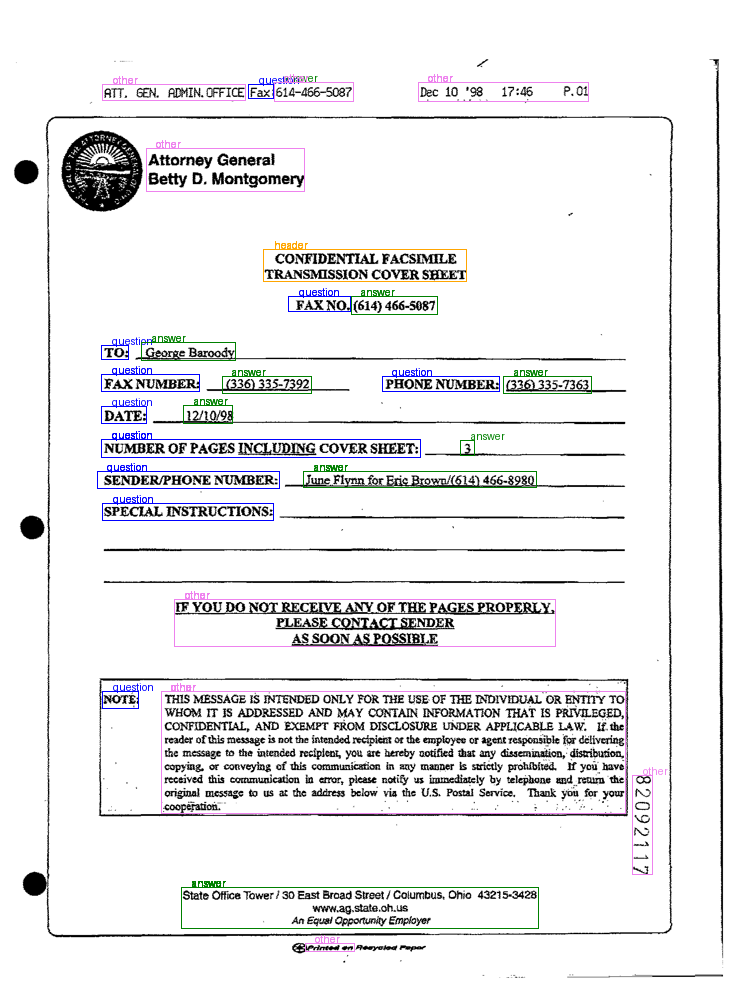

In [53]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

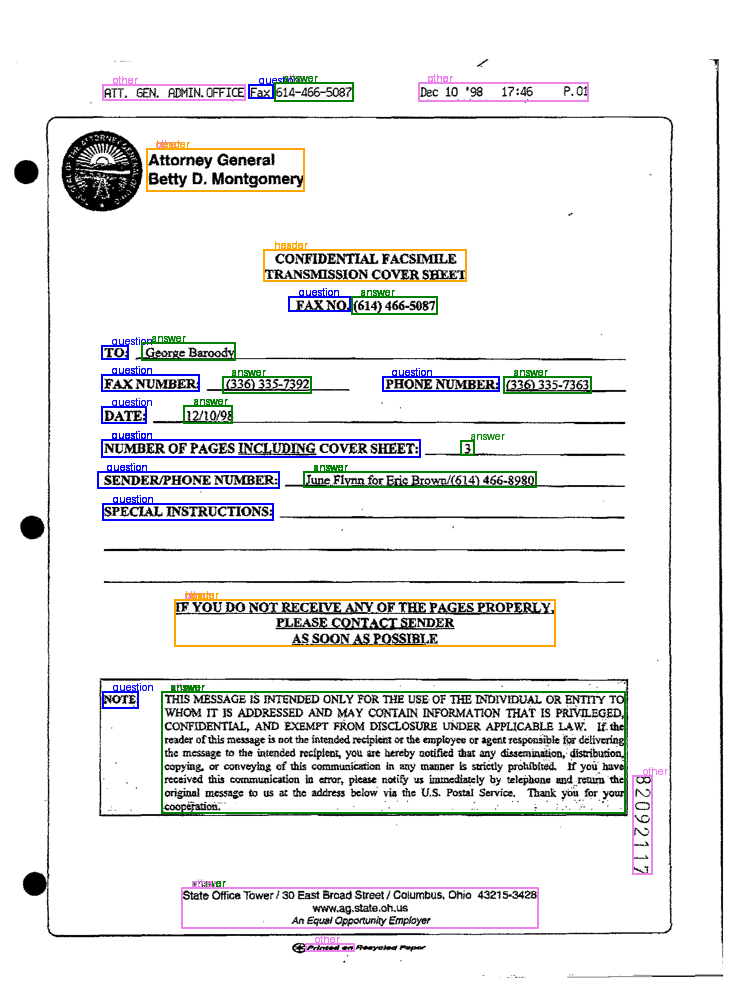

In [54]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image